# Y Splitter

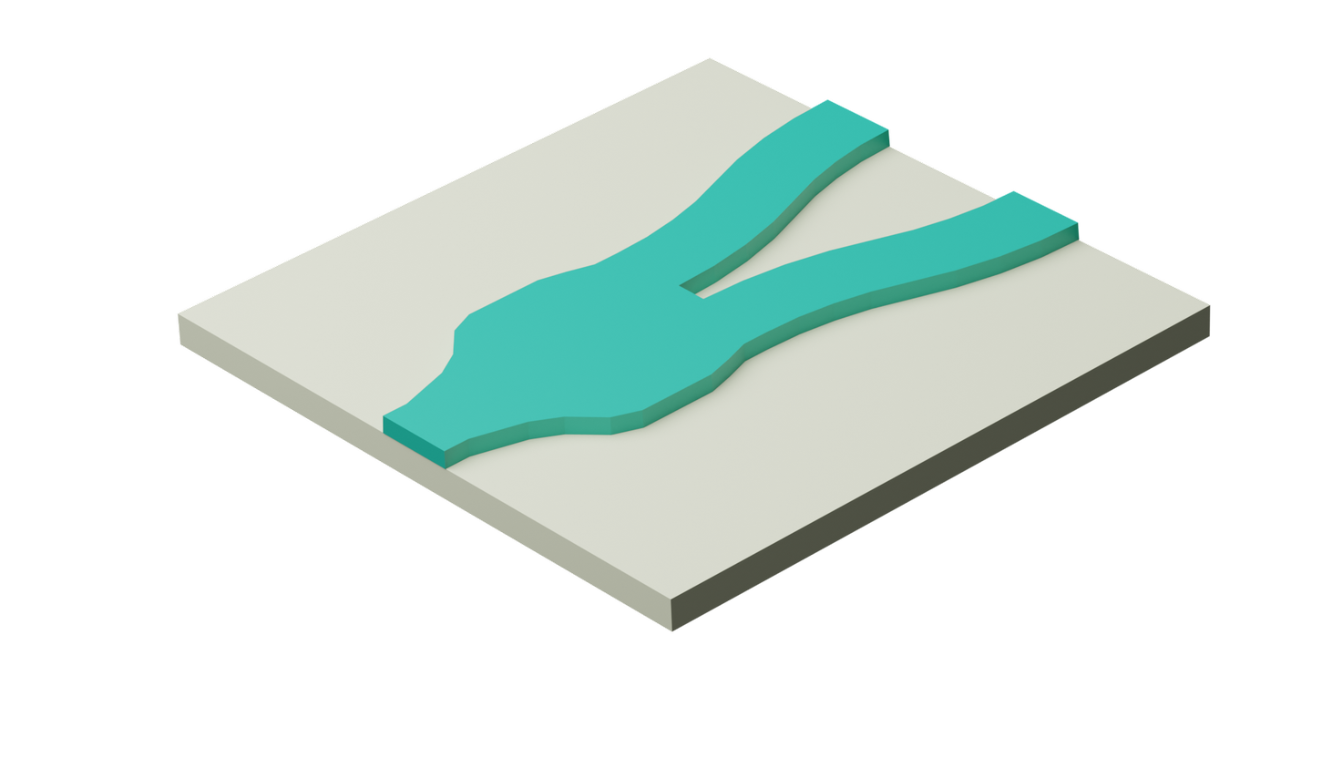

This example demonstrates the use of PhotonForge to design and simulate a simple Y splitter based on \[1].
We use the optimized geometry to create the splitter as a [component](../_autosummary/photonforge.Component.rst) with an FDTD model for performance verification.
After creating the geometry and setting up the component ports and model, we'll also demonstrate how to export it to the native PhotonForge format and to a GDSII file.

**References**

1. Yi Zhang, Shuyu Yang, Andy Eu-Jin Lim, Guo-Qiang Lo, Christophe Galland, Tom Baehr-Jones, and Michael Hochberg, "A compact and low loss Y-junction for submicron silicon waveguide," *Opt. Express* **21**, 1310-1316 (2013), doi: [10.1364/OE.21.001310](https://doi.org/10.1364/OE.21.001310)

This example has an equivalent in the Tidy3D documentation: [Waveguide Y junction](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/YJunction.html).

In [1]:
import numpy as np
import photonforge as pf
from matplotlib import pyplot as plt

## Technology

The first step is to set up the default technology for this project.
The original device is designed for a silicon-on-oxide (SOI) stack with a 220 nm thick device layer and a 500 nm wide waveguide.
The [basic_technology](../_autosummary/photonforge.basic_technology.rst) function defaults to those values, both for the stack and the `"Strip"` [port specification](../_autosummary/photonforge.PortSpec.rst).

In [2]:
tech = pf.basic_technology()
pf.config.default_technology = tech

Here we can inspect the layer, port, and extrusion specifications defined in our default technology:

In [3]:
print("Layer specifications:")
for name, spec in tech.layers.items():
    print(f"- {name}: {spec!r}")

Layer specifications:
- TRENCH: LayerSpec(layer=(4, 0), description="Deep-etched trench for chip facets", color="#48a78618", pattern="+")
- SLAB: LayerSpec(layer=(3, 0), description="Slab region", color="#f3840018", pattern=":")
- WG_CORE: LayerSpec(layer=(2, 0), description="Waveguide core", color="#0067a518", pattern="/")
- WG_CLAD: LayerSpec(layer=(1, 0), description="Waveguide clad", color="#84848218", pattern=".")


In [4]:
print("Port specifications:")
for name, spec in tech.ports.items():
    print(f"- {name}: {spec!r}")

Port specifications:
- Rib: PortSpec(description="Rib waveguide", width=2.16, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.4, 0, (1, 0)), (2.4, 0, (3, 0)), (0.4, 0, (2, 0))})
- Strip: PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))})


In [5]:
print("Extrusion specifications:")
for i, spec in enumerate(tech.extrusion_specs):
    print(f"{i + 1}. {spec!r}")

Extrusion specifications:
1. ExtrusionSpec(mask_spec=MaskSpec((2, 0)), medium=PoleResidue(attrs={}, name=None, frequency_range=(21413747041496.2, 249827048817455.7), allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='PoleResidue', eps_inf=1.0, poles=((6241549589084091j, -3.3254308736142404e+16j),)), limits=(0, 0.22), sidewall_angle=0)
2. ExtrusionSpec(mask_spec=MaskSpec((3, 0)), medium=PoleResidue(attrs={}, name=None, frequency_range=(21413747041496.2, 249827048817455.7), allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='PoleResidue', eps_inf=1.0, poles=((6241549589084091j, -3.3254308736142404e+16j),)), limits=(0, 0.07), sidewall_angle=0)
3. ExtrusionSpec(mask_spec=MaskSpec((4, 0)), medium=Medium(attrs={}, name=None, frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='Medium', permittivity=1.0, conductivity=0.0), limits=(-2e+07, 2e+07), sidewall_angle=0)


## Geometry

After the technology setup, we create the geometry, starting with the main polygon, as described in the reference work.

In [6]:
# Values from the optimized Y splitter
w = np.array((0.5, 0.5, 0.6, 0.7, 0.9, 1.26, 1.4, 1.4, 1.4, 1.4, 1.31, 1.2, 1.2))
length = 2.0
y_out = 0.35

vertices = np.vstack((np.linspace(0, length, len(w)), -0.5 * w)).T
y_polygon = pf.Polygon(np.vstack((vertices, vertices[::-1] * np.array((1, -1)))))

y_polygon

The output ports for this junction are very close to each other, which couples the modes from the 2 output waveguides.
S-parameter calculations assume that ports are independent, so there can be no coupling between modes from different ports, which means that we have 2 options:

1. Create a new port specification that includes both output waveguides and supports both modes, or
2. Physically separate the outputs so that we can use 2 independent strip waveguide ports.

The first solution means that components connecting to our splitter output would also have to use our new bimodal port, which is less convenient than the second solution.

Just for completeness, this is what the bimodal port specification would look like:

In [7]:
port_spec = pf.config.default_technology.ports["Strip"]

bimodal_clad_margin = 2 * (w[-1] + 2)
bimodal_port = pf.PortSpec(
    "Output test",
    width=0.9 * bimodal_clad_margin,
    limits=port_spec.limits,
    num_modes=2 * port_spec.num_modes,
    target_neff=port_spec.target_neff,
    path_profiles={
        (bimodal_clad_margin, 0, "WG_CLAD"),
        (0.5, y_out, "WG_CORE"),
        (0.5, -y_out, "WG_CORE"),
    },
)

We can export the port specification as a Tidy3D Mode Solver to inspect the port modes and verify that they are, indeed, coupled: the 2 single waveguide modes are split in a pair with different effective indices.
If the modes were uncoupled, they would have the same effective index as the isolated waveguide.

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.494696    0.0          0.984338   
             1                 1.55  2.475694    0.0          0.985276   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.799589        0.821479   0.386731  
             1                 0.741833        0.826490   0.366432

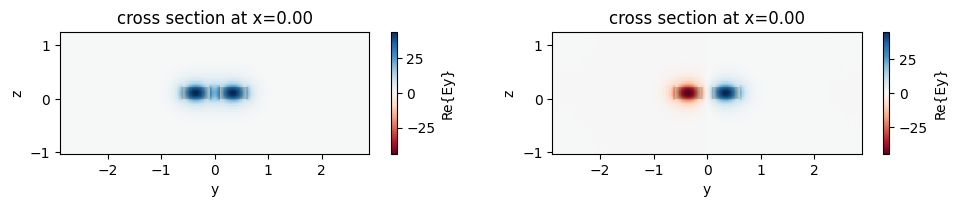

In [8]:
mode_solver = bimodal_port.to_tidy3d([pf.C_0 / 1.55], mesh_refinement=40)

_, ax = plt.subplots(1, 2, figsize=(10, 2), tight_layout=True)
mode_solver.plot_field("Ey", mode_index=0, robust=False, ax=ax[0])
mode_solver.plot_field("Ey", mode_index=1, robust=False, ax=ax[1])

mode_solver.data.to_dataframe()

We will go ahead with the second solution by splitting the outputs with conventional S bends.
We can use the [Path.s_bend](../_autosummary/photonforge.Path.rst#photonforge.Path.s_bend) function to build the core waveguide geometry.
The S bend offset is based on the port width to ensure the outputs have no overlap, and its length is chosen as a somewhat safe value to limit bend losses, but it can be fine-tuned reduce the component size if desired.

In [9]:
clad_width, _ = port_spec.path_profile_for("WG_CLAD")
core_width, _ = port_spec.path_profile_for("WG_CORE")
clad_margin = (clad_width - core_width) / 2

s_offset = clad_width / 2 - clad_margin / 2 - y_out
s_length = 5 * s_offset
s_bend1 = pf.Path((length, y_out), core_width).s_bend((s_length, s_offset), relative=True)
s_bend2 = pf.Path((length, -y_out), core_width).s_bend((s_length, -s_offset), relative=True)

y_splitter = pf.Component("Y_SPLITTER")
y_splitter.add("WG_CORE", y_polygon, s_bend1, s_bend2)

The basic technology includes a clad region by default in all port specifications.
We can add a clad region to the main polygon manually, by specifying it ourselves based on the polygons coordinates, or using the [envolope](../_autosummary/photonforge.envelope.rst) or [offset](../_autosummary/photonforge.offset.rst) functions.
The envelope is similar to the offset, but it is based on the convex hull of the structures, resulting in a convex polygon.

We use the envelope function making sure to limit the envelope in the x direction to have our ports at the boundaries of the component.
This is not strictly required, but can be helpful when connecting other components later or when using port [auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports).

If we want to preserve the size of the original clad, we can get the widths for the strip waveguide core and cladding sections from its [path profiles](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.path_profiles).
We're ignoring the offsets in the profiles here because we know, from our earlier inspection, that they are 0.

In [10]:
clad = pf.envelope(
    y_splitter.get_structures("WG_CORE"), clad_margin, trim_x_min=True, trim_x_max=True
)
y_splitter.add("WG_CLAD", clad)

## Ports

We can use [auto-detection](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports) to add the device ports.
That only works because we've added the cladding *edges* required by the Strip specification.

In [11]:
candidates = y_splitter.detect_ports(["Strip"])
candidates

[Port(center=(0, 0), input_direction=0, spec=PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))}), extended=True, inverted=False),
 Port(center=(4, -0.75), input_direction=180, spec=PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))}), extended=True, inverted=False),
 Port(center=(4, 0.75), input_direction=180, spec=PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))}), extended=True, inverted=False)]

Once we confirm the ports are correctly detected, we add them:

In [12]:
y_splitter.add_port(candidates)
y_splitter

## Model

We add a [Tidy3DModel](../_autosummary/photonforge.Tidy3DModel.rst) to the component to simulate it using FDTD.
Because of the device symmetry, we don't need to excite both ports P1 and P2: the parameters extracted from the excitation of P2 can be computed from the excitation of P1, that is $S_{n2} = S_{m1}$, with $m$ and $n$ given by dictionary `{m: n, …}`.
That mapping is established by `port_symmetries`, in which we indicate that we want to use the excitation of P1 to compute the parameters from P2 by mapping P1 to P2 (sources, $S_{22} = S_{11}$), P0 to itself ($S_{02} = S_{01}$), and P2 to P1 ($S_{12} = S_{21}$).

In [13]:
tidy3d_model = pf.Tidy3DModel(port_symmetries=[("P1", "P2", {"P0": "P0", "P2": "P1"})])
y_splitter.add_model(tidy3d_model, "Tidy3D")

y_splitter.active_model

Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=(), structures=(), grid_spec=None, shutoff=1e-05, subpixel=True, courant=0.99, port_symmetries=[('P1', 'P2', {'P0': 'P0', 'P2': 'P1', 'P1': 'P2'})], bounds=((None, None, None), (None, None, None)), verbose=True)

## S parameters

With the model and ports set up, calculating the S parameters is a simple call to the [s_matrix](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) function with the desired frequencies:

In [14]:
lda = np.linspace(1.5, 1.6, 11)
freqs = pf.C_0 / lda

s_matrix = y_splitter.s_matrix(freqs)

Starting...
Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-HU3ODD7YIRPDBOPVGN3DYIF6KAOZVLLR3JZY45AWXOA3G7IWAZWQ.json.
Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-ZMVIDPFCFCXYITOLT4KTJLA66J7E6EDWJWUHSZ7IGCXB3V33KJPQ.json.
Progress: 100% 


The S matrix can be sparse, so it stores the elements as a dictionary indexed by tuples of origin and destination ports.
Because each port can support multiple modes, the mode index is appended to the port name in the S dictionary keys after the `@` character:

In [15]:
print(s_matrix.elements.keys())

dict_keys([('P2@0', 'P0@0'), ('P2@0', 'P1@0'), ('P0@0', 'P0@0'), ('P0@0', 'P1@0'), ('P0@0', 'P2@0'), ('P1@0', 'P0@0'), ('P2@0', 'P2@0'), ('P1@0', 'P1@0'), ('P1@0', 'P2@0')])


For example, the element $S_{10}$, representing the transmission coefficient from P0 to P1 can be retrieved as:

In [16]:
s_matrix[("P0@0", "P1@0")]

array([ 0.52363982+0.44306141j,  0.66783291+0.16623079j,
        0.67512207-0.14284466j,  0.5483593 -0.42120998j,
        0.31687221-0.61563485j,  0.02834722-0.69233305j,
       -0.261886  -0.64163622j, -0.50174388-0.47762465j,
       -0.6514537 -0.23349963j, -0.68944123+0.0459838j ,
       -0.61431551+0.31327002j])

The utility function [plot_s_matrix](../_autosummary/photonforge.plot_s_matrix.rst) can be used to quickly plot the S parameters.
We use only ports P0 and P1 as input ports for plotting, because the input from P2 is the same as from P1 (according to our symmetry settings).

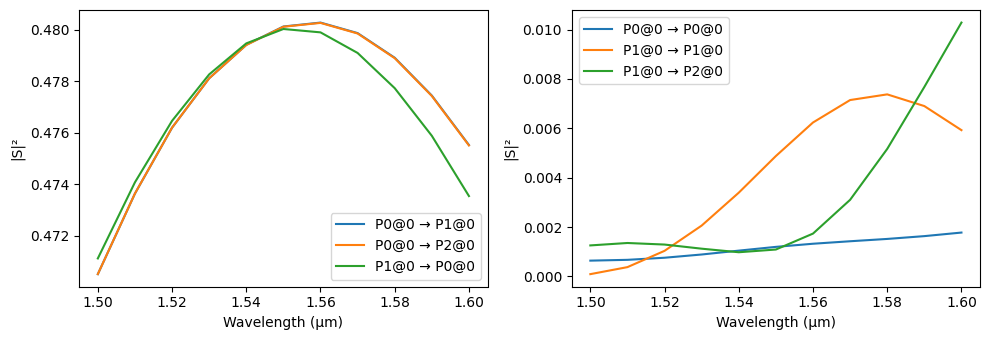

In [17]:
fig, ax = pf.plot_s_matrix(s_matrix, input_ports=["P0", "P1"])

## Inspecting the Fields

It is possible to obtain the field distributions in the device by adding a [field monitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html#tidy3d.FieldMonitor) to the Tidy3D model.
We have to re-run the simulation to use the new model and then get the simulation data for plotting.

In [18]:
import tidy3d as td

tidy3d_model_with_monitor = pf.Tidy3DModel(
    port_symmetries=[("P1", "P2", {"P0": "P0", "P2": "P1"})],
    monitors=[
        td.FieldMonitor(
            name="field",
            center=(0, 0, 0.11),
            size=(td.inf, td.inf, 0),
            freqs=[freqs[freqs.size // 2]],
        )
    ],
)
y_splitter.add_model(tidy3d_model_with_monitor, "Tidy3DModel with monitor")

s_matrix = y_splitter.s_matrix(freqs)

Starting...


Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-VVPDE67PYKRYYL3DH553FULWPYORYFU7ZMWS34BTOEOFIPJO2QLQ.json.
Loading cached simulation from .tidy3d/pf_cache/7HL/fdtd_info-MA44UMSPD6TQGNDMVR3XVCOZ66FB7QDS7ROPQHL3FIDBZZMNW3FQ.json.
Progress: 100% 


The simulation data is stored by the model, so we need to call `batch_data_for` on the model, passing the splitter as an argument.
The returned value is a [BatchData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.BatchData.html) object, so we can inspect the simulations it stored from its `task_ids` dictionary:

In [19]:
sim_data = tidy3d_model_with_monitor.batch_data_for(y_splitter)
sim_data.task_ids

{'P0@0': 'fdve-81fa157a-926b-48d0-ab4f-1e6c90164ce2',
 'P1@0': 'fdve-9fbf7cd7-fe67-4bfd-beda-6aed06c5f060'}

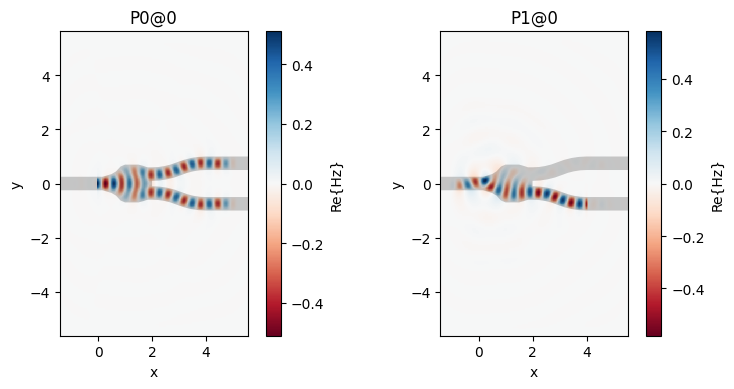

In [20]:
_, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

for i, name in enumerate(sorted(sim_data.task_ids)):
    sim_data[name].plot_field("field", "Hz", robust=False, ax=ax[i])
    ax[i].set_title(name)

## Saving and Exporting

The final component can be saved to a native PhotonForge project file (.phf), which stores all information associated with the component (including parametric arguments, for example).
This file is also compatible with our [web UI](https://tidy3d.simulation.cloud/), if we want to continue using the splitter via GUI.

Note that the function [write_phf](../_autosummary/photonforge.write_phf.rst) can store several components (or technologies) in a single file, and it includes all dependencies automatically.
For example, when we store the `y_splitter` component, the `s_bend` will also be included, as well as the basic technology they use.

In [21]:
pf.write_phf("Y_Splitter.phf", y_splitter)

Just for demonstration, we can load the created file to check its contents:

In [22]:
contents = pf.load_phf("Y_Splitter.phf")

print("Loaded components:", len(contents["components"]))
for c in contents["components"]:
    print(
        f"- {c} (structures: {len(c.structures)}; references: {len(c.references)}; ports: {len(c.ports)}; models: {len(c.models)})"
    )

print("Loaded technologies:", len(contents["technologies"]))
for t in contents["technologies"]:
    print(f"- {t}")

Loaded components: 1
- Component "Y_SPLITTER" (structures: 2; references: 0; ports: 3; models: 2)
Loaded technologies: 0


Although we don't see the S bend or the basic technology in the contents, they are stored within the loaded splitter.
By default, [load_phf](../_autosummary/photonforge.load_phf.rst) will only list the explicitly saved items the returned dictionary.
We can change that by setting `only_explicit` to `False`:

In [23]:
contents = pf.load_phf("Y_Splitter.phf", only_explicit=False)

print("Loaded components:", len(contents["components"]))
for c in contents["components"]:
    print(
        f"- {c} (structures: {len(c.structures)}; references: {len(c.references)}; ports: {len(c.ports)}; models: {len(c.models)})"
    )

print("Loaded technologies:", len(contents["technologies"]))
for t in contents["technologies"]:
    print(f"- {t}")

Loaded components: 1
- Component "Y_SPLITTER" (structures: 2; references: 0; ports: 3; models: 2)
Loaded technologies: 1
- Basic Technology 1.0


Finally, we can also export the device to a GDSII or an OASIS file (methods [write_gds](../_autosummary/photonforge.Component.rst#photonforge.Component.write_gds) and [write_oas](../_autosummary/photonforge.Component.rst#photonforge.Component.write_oas) can be used to quickly export a single component, and function [write_layout](../_autosummary/photonforge.write_layout.rst) for multiple components in a single file).
Those interchange formats do not store all information available in the component, such as technology specifications or modes, so [loading](../_autosummary/photonforge.load_layout.rst) back from them will not result in the original component.

In [24]:
y_splitter.write_gds("Y_Splitter.gds")

contents = pf.load_layout("Y_Splitter.gds")

print("Loaded components:", len(contents))
for _, c in contents.items():
    print(
        f"- {c} (structures: {len(c.structures)}; references: {len(c.references)}; ports: {len(c.ports)}; models: {len(c.models)})"
    )

Loaded components: 1
- Component "Y_SPLITTER" (structures: 2; references: 0; ports: 0; models: 0)
